# Load and merge the surveys into one

Now comes the fun part. We need to load all the surveys and merge them into a single file/`Dataset`. To do that, we need to make sure:

* Metadata is standard for all surveys (and preserved in the merger).
* The `Dataset` is in a usable format.
* Coordinates are all WGS84 for easier manipulation.
* We can access the absolute gravity and do our own corrections.

This should be fun...

In [58]:
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pygmt
import pyproj
import glob

In [4]:
xr.open_dataset("../data/000a522322d3c7d2fd97bf91ba7179e6-P198362-point-gravity.nc")

<xarray.Dataset>
Dimensions:                          (elipsoiddatum: 1, ellipsoidhgtaccmethod: 7, ellipsoidhgtmeth: 22, ellipsoidinsthgterrmethod: 7, gndelevaccmethod: 7, gndelevdatum: 9, gndelevmeth: 22, gndelevtype: 12, gravaccmeth: 7, gravmeth: 44, gridflag: 3, insthgterrmeth: 7, insthgtmeth: 22, locaccmethod: 7, locmethod: 13, point: 73, reliab: 10, stattype: 24, tcmeth: 15)
Coordinates:
  * locmethod                        (locmethod) object 'Positions digitised ...
  * locaccmethod                     (locaccmethod) object 'Value taken as re...
  * stattype                         (stattype) object 'Absolute measurement'...
  * gravmeth                         (gravmeth) object 'Pendulum observation ...
  * gravaccmeth                      (gravaccmeth) object 'Value taken as rep...
  * gndelevtype                      (gndelevtype) object 'Marine' ... 'Unkno...
  * gndelevdatum                     (gndelevdatum) object 'Australian Height...
  * gndelevmeth                      (gndelevmeth) object 'Value measured by ...
  * gndelevaccmethod                 (gndelevaccmethod) object 'Value taken a...
  * insthgtmeth                      (insthgtmeth) object 'Value measured by ...
  * insthgterrmeth                   (insthgterrmeth) object 'Value taken as ...
  * ellipsoidinsthgterrmethod        (ellipsoidinsthgterrmethod) object 'Valu...
  * ellipsoidhgtmeth                 (ellipsoidhgtmeth) object 'Value measure...
  * ellipsoidhgtaccmethod            (ellipsoidhgtaccmethod) object 'Value ta...
  * elipsoiddatum                    (elipsoiddatum) object 'GRS80'
  * tcmeth                           (tcmeth) object 'Method developed by Fea...
  * gridflag                         (gridflag) object 'Station not used in t...
  * reliab                           (reliab) object 'Unreliable data which s...
Dimensions without coordinates: point
Data variables:
    crs                              int8 ...
    ga_gravity_metadata              int8 ...
    obsno                            (point) float64 ...
    latitude                         (point) float64 ...
    longitude                        (point) float64 ...
    locmethod_index                  (point) float32 ...
    locacc                           (point) float32 ...
    locaccmethod_index               (point) float32 ...
    stattype_index                   (point) float32 ...
    grav                             (point) float64 ...
    gravmeth_index                   (point) float32 ...
    freeair                          (point) float32 ...
    bouguer                          (point) float32 ...
    gravacc                          (point) float32 ...
    gravaccmeth_index                (point) float32 ...
    gndelev                          (point) float32 ...
    gndelevacc                       (point) float32 ...
    gndelevtype_index                (point) float32 ...
    gndelevdatum_index               (point) float32 ...
    gndelevmeth_index                (point) float32 ...
    gndelevaccmethod_index           (point) float32 ...
    insthgt                          (point) float32 ...
    insthgterr                       (point) float32 ...
    insthgtmeth_index                (point) float32 ...
    insthgterrmeth_index             (point) float32 ...
    ellipsoidinsthgt                 (point) float32 ...
    ellipsoidinsthgterr              (point) float32 ...
    ellipsoidinsthgterrmethod_index  (point) float32 ...
    ellipsoidhgt                     (point) float32 ...
    ellipsoidhgtacc                  (point) float32 ...
    ellipsoidhgtmeth_index           (point) float32 ...
    ellipsoidhgtaccmethod_index      (point) float32 ...
    elipsoiddatum_index              (point) float32 ...
    tc                               (point) float32 ...
    tcdensity                        (point) float32 ...
    tcerr                            (point) float32 ...
    tcmeth_index                     (point) float32 ...
    gridflag_index

In [2]:
all_surveys = [xr.open_dataset(fname) for fname in tqdm(glob.glob("../data/*.nc"))]

100%|██████████| 1631/1631 [01:19<00:00, 20.40it/s]


In [10]:
reliability = [np.unique(s.reliab_index) for s in all_surveys]

In [17]:
really_bad = [np.any(r == 0) for r in reliability]
bad = [np.any(r == 2) for r in reliability]
not_good = [np.any(r == 3) for r in reliability]
print(f"Really bad: {sum(really_bad)}")
print(f"       Bad: {sum(bad)}")
print(f"  Not good: {sum(not_good)}")

Really bad: 0
       Bad: 32
  Not good: 109


Remove the bad surveys at least. The "not good" ones we can down weight during gridding.

In [21]:
surveys = [survey for survey, reliability in zip(all_surveys, reliability) if not np.any(reliability == 2)]
print(len(surveys))

1599


In [25]:
ndata_per_survey = [s.grav.size for s in surveys]
print(sum(ndata_per_survey))

1789824


In [29]:
a = surveys[0]
a

<xarray.Dataset>
Dimensions:                          (elipsoiddatum: 1, ellipsoidhgtaccmethod: 7, ellipsoidhgtmeth: 22, ellipsoidinsthgterrmethod: 7, gndelevaccmethod: 7, gndelevdatum: 9, gndelevmeth: 22, gndelevtype: 12, gravaccmeth: 7, gravmeth: 44, gridflag: 3, insthgterrmeth: 7, insthgtmeth: 22, locaccmethod: 7, locmethod: 13, point: 1635, reliab: 10, stattype: 24, tcmeth: 15)
Coordinates:
  * locmethod                        (locmethod) object 'Positions digitised ...
  * locaccmethod                     (locaccmethod) object 'Value taken as re...
  * stattype                         (stattype) object 'Absolute measurement'...
  * gravmeth                         (gravmeth) object 'Pendulum observation ...
  * gravaccmeth                      (gravaccmeth) object 'Value taken as rep...
  * gndelevtype                      (gndelevtype) object 'Marine' ... 'Unkno...
  * gndelevdatum                     (gndelevdatum) object 'Australian Height...
  * gndelevmeth                      (gndelevmeth) object 'Value measured by ...
  * gndelevaccmethod                 (gndelevaccmethod) object 'Value taken a...
  * insthgtmeth                      (insthgtmeth) object 'Value measured by ...
  * insthgterrmeth                   (insthgterrmeth) object 'Value taken as ...
  * ellipsoidinsthgterrmethod        (ellipsoidinsthgterrmethod) object 'Valu...
  * ellipsoidhgtmeth                 (ellipsoidhgtmeth) object 'Value measure...
  * ellipsoidhgtaccmethod            (ellipsoidhgtaccmethod) object 'Value ta...
  * elipsoiddatum                    (elipsoiddatum) object 'GRS80'
  * tcmeth                           (tcmeth) object 'Method developed by Fea...
  * gridflag                         (gridflag) object 'Station not used in t...
  * reliab                           (reliab) object 'Unreliable data which s...
Dimensions without coordinates: point
Data variables:
    crs                              int8 ...
    ga_gravity_metadata              int8 ...
    obsno                            (point) float64 ...
    latitude                         (point) float64 -31.56 -31.56 ... -31.21
    longitude                        (point) float64 140.1 140.1 ... 140.2 140.7
    locmethod_index                  (point) float32 ...
    locacc                           (point) float32 ...
    locaccmethod_index               (point) float32 ...
    stattype_index                   (point) float32 ...
    grav                             (point) float64 9.794e+06 ... 9.794e+06
    gravmeth_index                   (point) float32 ...
    freeair                          (point) float32 ...
    bouguer                          (point) float32 ...
    gravacc                          (point) float32 0.5 0.5 0.5 ... 0.5 0.5 0.5
    gravaccmeth_index                (point) float32 ...
    gndelev                          (point) float32 ...
    gndelevacc                       (point) float32 ...
    gndelevtype_index                (point) float32 ...
    gndelevdatum_index               (point) float32 ...
    gndelevmeth_index                (point) float32 ...
    gndelevaccmethod_index           (point) float32 ...
    insthgt                          (point) float32 ...
    insthgterr                       (point) float32 ...
    insthgtmeth_index                (point) float32 ...
    insthgterrmeth_index             (point) float32 ...
    ellipsoidinsthgt                 (point) float32 111.654 112.496 ... 67.485
    ellipsoidinsthgterr              (point) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ellipsoidinsthgterrmethod_index  (point) float32 ...
    ellipsoidhgt                     (point) float32 ...
    ellipsoidhgtacc                  (point) float32 ...
    ellipsoidhgtmeth_index           (point) float32 ...
    ellipsoidhgtaccmethod_index      (point) float32 ...
    elipsoiddatum_index              (point) float32 ...
    tc                               (point) float32 ...
    tcdensity                        (point) float3

In [79]:
dims = ("point", )
transformer = pyproj.Transformer.from_crs("epsg:4283", "epsg:4326", always_xy=True)
datasets = []
for survey in tqdm(surveys, ncols=100):
    # Transform coordinates to WGS84
    lon, lat, h = transformer.transform(
        survey.longitude.values, 
        survey.latitude.values.astype(np.float32), 
        survey.ellipsoidinsthgt.values.astype(np.float32),
    )
    dataset = xr.Dataset(
        data_vars={
            "gravity": (dims, survey.grav.astype(np.float32) / 10),
            "gravity_accuracy": (dims, survey.gravacc),
            "height_error": (dims, survey.ellipsoidinsthgterr),
            "reliability_index": (dims, survey.reliab_index.astype(np.int8)),
        },
        coords={
            "longitude": (dims, lon.astype(np.float32)),
            "latitude": (dims, lat.astype(np.float32)),
            "height": (dims, h.astype(np.float32)),
        },
    )
    datasets.append(dataset)

100%|███████████████████████████████████████████████████████████| 1599/1599 [00:22<00:00, 70.02it/s]


In [88]:
data = xr.concat(datasets, "point")
data.attrs = {
    "Conventions": "CF-1.8",
    "title": "Compilation of gravity ground surveys for Australia",
    "institution": "Commonwealth of Australia (Geoscience Australia)",
    "crs": "WGS84",
    "source": (
        "Compiled from the collection by Wynne, P. 2018. "
        "NetCDF Ground Gravity Point Surveys Collection. Geoscience Australia, Canberra. "
        "https://doi.org/10.26186/5c1987fa17078 "
    ),    
    "uuid": "d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1",
    "license": "Creative Commons Attribution 4.0 International Licence",
    "references": "https://doi.org/10.26186/5c1987fa17078",   
    "history": (
        f"{datetime.datetime.now().astimezone().isoformat(timespec='seconds')} : "
        "Data with reliability index of 0 or 2 were removed from the compilation. "
        "Coordinates were converted to WGS84. "
        "Gravity was converted to mGal. "
        "Only absolute gravity, latitude, longitude, and ellipsoid height were kept. "
    ),     
}
data.gravity.attrs = {
    "long_name": "gravity acceleration",
    "units": "mGal",
    "actual_range": (data.gravity.values.min(), data.gravity.values.max()),
    "ancillary_variables": ["gravity_accuracy"],
    "description": "magnitude of the gravity acceleration vector",
}
data.gravity_accuracy.attrs = {
    "long_name": "accuracy of gravity acceleration",
    "units": "mGal",
    "actual_range": (data.gravity_accuracy.values.min(), data.gravity_accuracy.values.max()),
    "description": "accuracy of the magnitude of the gravity acceleration vector",
}
data.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (data.longitude.values.min(), data.longitude.values.max()),
}
data.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (data.latitude.values.min(), data.latitude.values.max()),
}
data.height.attrs = {
    "long_name": "geometric height",
    "standard_name": "height_above_reference_ellipsoid",
    "units": "m",
    "actual_range": (data.height.values.min(), data.height.values.max()),
    "description": "height above the WGS84 ellipsoid",
}
data.height_error.attrs = {
    "long_name": "geometric height error",
    "units": "m",
    "actual_range": (data.height_error.values.min(), data.height_error.values.max()),
    "description": "error in the height above the WGS84 ellipsoid",
}

data

<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float32 140.08472 140.09459 ... 136.08089
    latitude           (point) float32 -31.558207 -31.557846 ... -33.503056
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) int8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-09T18:20:37+01:00 : Data with reliability index of ...

In [91]:
data.to_netcdf("../data/australia-ground-gravity.nc", format="NETCDF4")

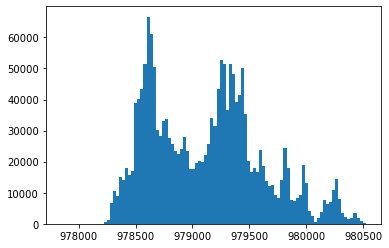

In [89]:
plt.hist(data.gravity.values, bins=100)
plt.show()

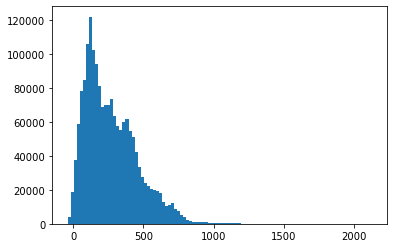

In [90]:
plt.hist(data.height.values, bins=100)
plt.show()